In [ ]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import os
import pandas as pd

if os.name == "nt":
    plt.rcParams["font.family"] = "Meiryo"
elif os.name == "posix":
    plt.rcParams["font.family"] = "Hiragino Sans"

SEED = 42

In [27]:
IMAGE_DIR = os.getcwd().replace('code','images')
DATA_DIR = os.getcwd()
os.makedirs(IMAGE_DIR,exist_ok=True)

## シミュレーションのためのデータ作成

10歳時の身長は以下の回帰によって決まるものとする

$$
身長 = 父親の身長と母親の身長の平均(cm)*.8 + 男であること*10 + 運動時間(h) * 0.01 + 牛乳 \times 運動 * 0.07 + \epsilon(~normal(0,10))
$$

In [28]:
np.random.seed(SEED)
s = 120

father = np.random.normal(170,5,size=s)
mother = np.random.normal(155,5,size=s)
sex = np.random.binomial(n=1,p=0.5,size=s)
activity = np.random.normal(5,1,size=s)+sex*1
milk= np.random.normal(1,0.2,size=s)
error = np.random.normal(0,10,size=s)

x = np.array([
    (father+mother)/2,
    sex,
    activity,
    milk,
    milk*activity,
    ]).T
beta = np.array([
    .85,
    5,
    0.1,
    0.05,
    1,
    ]).reshape(-1,1)

In [29]:
df = pd.DataFrame(dict(
	father = father,
	mother = mother,
	sex = sex,
	activity = activity,
	milk = milk,
	height = np.dot(x,beta)[:,0]
))

In [30]:
df.describe()

,father,mother,sex,activity,milk,height
count,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000
mean,169.604155,155.371821,0.491667,5.488045,0.976926,146.495950
std,4.626583,5.061526,0.502027,1.111562,0.201700,4.456625
min,156.901274,144.874287,0.000000,2.876104,0.505671,136.140771
25%,167.140623,151.207458,0.000000,4.870924,0.845666,143.066593
50%,169.633860,155.927720,0.000000,5.401168,0.965398,146.343449
75%,171.913931,158.311573,1.000000,6.344785,1.109652,149.651067
max,182.316211,174.263657,1.000000,8.189803,1.615776,159.533859


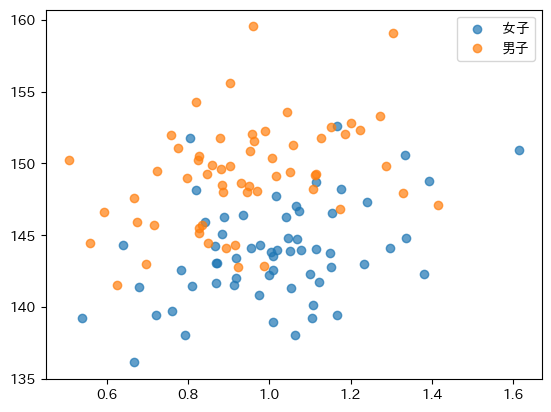

In [31]:
for i,s in enumerate(['女子','男子']):
	plt.scatter(
		df.loc[df.sex==i].milk,
		df.loc[df.sex==i].height,
		alpha=.7,
		label = s
	)

plt.legend()

In [32]:
df.to_pickle(f'{DATA_DIR}/dummy_data.pkl')

In [33]:
df=pd.read_pickle(f'{DATA_DIR}/dummy_data.pkl')


In [34]:
y = df.height
x = df.milk

In [35]:
np.var(x,ddof=1)

0.04068300314064104

In [36]:
cov = np.cov(x,y,ddof=1)
r = cov[0,1]/np.sqrt(cov[0,0]*cov[1,1])
r
# beta_2 = cov[0,1]/cov[0,0]
# beta_1 = np.mean(y)-beta_2*np.mean(x)
# r_square = np.sum(np.power(y_hat-np.mean(y),2))/np.sum(np.power(y-np.mean(y),2))
# r = np.sqrt(r_square)
# print('beta_1',beta_1)
# print('beta_2',beta_2)
# print('r_2',r_square)
# print('r',r)

0.20086681163540904

In [37]:
cov = np.cov(x,y,ddof=0)
r = cov[0,1]/np.sqrt(cov[0,0]*cov[1,1])
r

0.2008668116354091

In [38]:
cov

array([[ 0.04034398,  0.17905502],
       [ 0.17905502, 19.695994  ]])

In [40]:
cov = np.cov(x,y,ddof=0)
beta_2 = cov[0,1]/cov[0,0]
beta_1 = np.mean(y)-beta_2*np.mean(x)

y_hat = beta_1 + beta_2 * x

r_square = np.sum(np.power(y_hat-np.mean(y),2))/np.sum(np.power(y-np.mean(y),2))
r = np.sqrt(r_square)

print('beta_1',beta_1)
print('beta_2',beta_2)
print('r_2',r_square)
print('r',r)

beta_1 142.1601494948339
beta_2 4.438209287295184
r_2 0.04034747601657481
r 0.20086681163540882


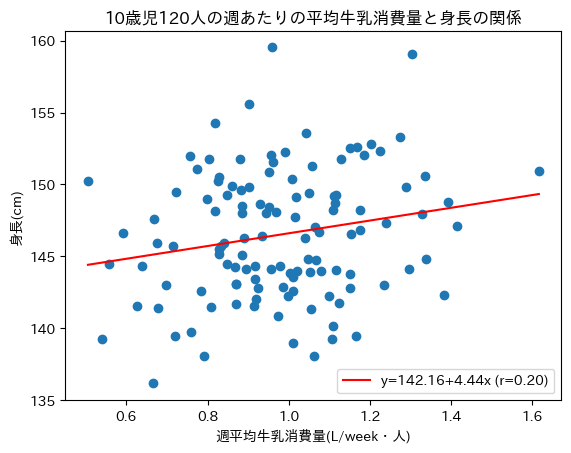

In [41]:
x_ = np.linspace(np.min(x),np.max(x),100)
y_ = beta_1 + beta_2 * x_
fomula = f'y={beta_1:.2f}+{beta_2:.2f}x (r={r:.2f})'

plt.tight_layout()
plt.scatter(x,y)
plt.plot(
    x_,
    y_,
    color = 'r',
    label = fomula,
)
plt.legend(loc='best')
plt.xlabel('週平均牛乳消費量(L/week・人)')
plt.ylabel('身長(cm)')
plt.title('10歳児120人の週あたりの平均牛乳消費量と身長の関係')
plt.savefig(f'{IMAGE_DIR}/figure_milk_vs_height')

In [42]:
print(f'r_sq : {r_square}')
print(f'r : {np.sqrt(r_square)}')

r_sq : 0.04034747601657481
r : 0.20086681163540882


In [274]:
x

0      0.889270
1      0.760424
2      1.392945
3      1.007053
4      0.860055
         ...   
115    0.956180
116    1.165881
117    0.557773
118    1.047123
119    1.154173
Name: milk, Length: 120, dtype: float64

In [279]:
from sklearn.linear_model import LinearRegression

x = np.array(x).reshape(-1,1)
y = np.array(y)

lr = LinearRegression().fit(x,y)

In [280]:
coef_ = lr.coef_
y_hat = lr.predict(x)

sse = np.sum((y-y_hat)**2,axis=0)
sse = sse/(x.shape[0] - x.shape[1]-1)

s = np.linalg.inv(np.dot(x.T,x))

std_err = np.sqrt(np.diagonal(sse * s))

print("std_err :", std_err)

t = coef_/std_err

print('t :',t)

std_err : [0.40128492]
t : [11.05999508]


In [181]:
y_hat

array([152.44043827, 155.82078262, 159.20112697, 162.58147132,
       165.96181567, 169.34216002, 172.72250437, 176.10284872,
       179.48319307, 182.86353742, 186.24388177, 189.62422612,
       193.00457047, 196.38491482, 199.76525917, 203.14560352,
       206.52594787, 209.90629222, 213.28663657, 216.66698092,
       220.04732527, 223.42766962, 226.80801397, 230.18835832,
       233.56870267, 236.94904702, 240.32939137, 243.70973572,
       247.09008007, 250.47042442, 253.85076877, 257.23111312,
       260.61145747, 263.99180182, 267.37214617, 270.75249052,
       274.13283487, 277.51317922, 280.89352357, 284.27386792,
       287.65421227, 291.03455662, 294.41490097, 297.79524532,
       301.17558967, 304.55593402, 307.93627837, 311.31662272,
       314.69696707, 318.07731142, 321.45765577, 324.83800012,
       328.21834447, 331.59868882, 334.97903317, 338.35937752,
       341.73972187, 345.12006622, 348.50041057, 351.88075492,
       355.26109927, 358.64144362, 362.02178797, 365.40

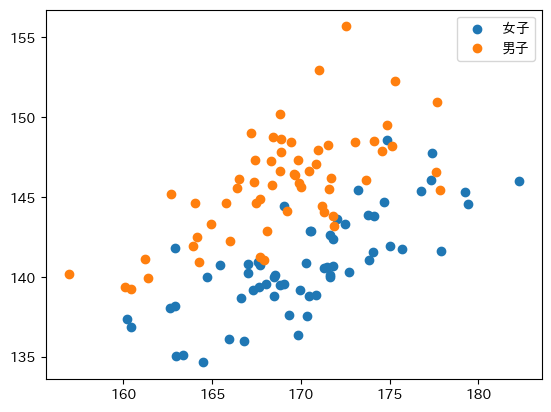

In [169]:
for i,s in enumerate(['女子','男子']):
	plt.scatter(
		df.loc[df.sex==i].father,
		df.loc[df.sex==i].height,
		label = s
	)

plt.legend()